In [399]:
from package_nanonis.nanonis_sxm import * 
import numpy as np 
import matplotlib.pyplot as plt
from package_utils.cmap_custom import nanox
from skimage.feature import peak_local_max
from skimage.io import imread # read/load the input image
from scipy import ndimage # affine transformation
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance
import math
import cv2

### FFT

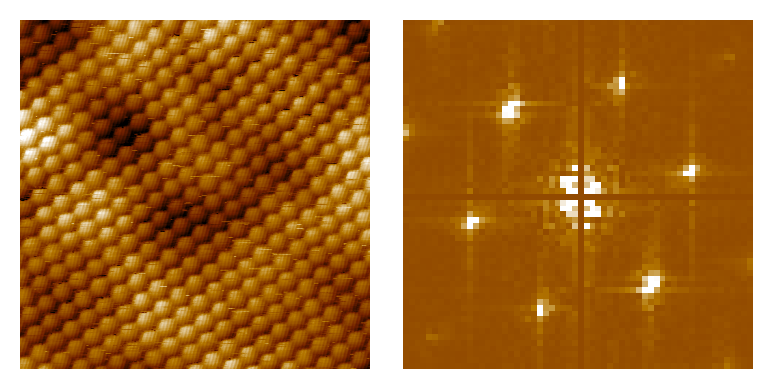

In [14]:
# Topography settings
topo = topography('Topo/Au111_W_LN2_0689.sxm')
topo1 = topo.get_z('subtract linear fit xy','fwd')

# Header
ScanPixels = topo.header['scan_pixels']
ScanRange = topo.header['scan_range']
ScanDir = str(topo.header['scan_dir']).lower()
if ScanDir == 'down':
        origin = 'upper'
elif ScanDir == 'up':
        origin = 'lower'

# plt settings
mm = 25.4
a = 100 / mm # width
b = 50 / mm # height
plt.rcParams['figure.figsize'] = (a,b)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.xmargin'] = 0
# plt.rcParams['axes.ymargin'] = 0
fontsize=10

# FFT
topo1fft = fft.two_d_FFT_lin(topo1)
# topo1fft = fft.two_d_FFT_log(topo1)
# topo1fft = fft.two_d_FFT_sqrt(topo1)

# FFT image crop
center = round(ScanPixels[0]/2)
croppx = 30
topo1fftcrop = topo1fft[center-croppx:center+croppx, center-croppx:center+croppx]

# plot
fig, ax = plt.subplots(1,2)
sigma = 3
vmin = np.mean(topo1) - sigma*np.std(topo1)
vmax = np.mean(topo1) + sigma*np.std(topo1)
aspect = (ScanPixels[0]/ScanPixels[1])*(ScanRange[1]/ScanRange[0])
ax[0].imshow(topo1, origin=origin, vmin=vmin, vmax=vmax, cmap=nanox(), aspect=aspect)
ax[0].axis('off')

sigma = 30
vmin = np.mean(topo1fft) - sigma*np.std(topo1fft)
vmax = np.mean(topo1fft) + sigma*np.std(topo1fft)
ax[1].imshow(topo1fftcrop, origin=origin, vmin=vmin, vmax=vmax, cmap=nanox(), aspect=aspect)
ax[1].axis('off')

plt.tight_layout(pad=1)

### Find Peaks

[[15 18]
 [45 42]
 [34 11]
 [26 49]
 [11 37]
 [49 23]]


(-0.5, 59.5, 59.5, -0.5)

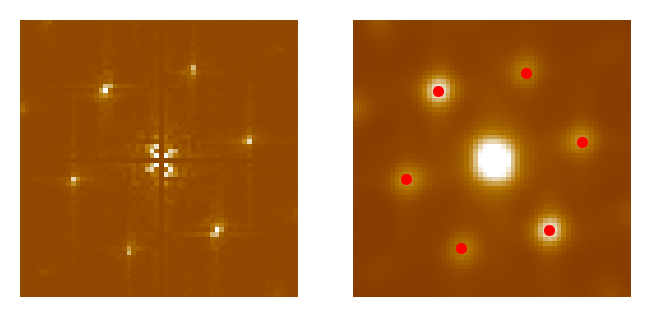

In [178]:
topo1fftcrop_gaussian = gaussian_filter(topo1fftcrop, sigma=2)
min_distance = 7
lmax_coords = peak_local_max(topo1fftcrop_gaussian, min_distance=min_distance)
lmax_coords = np.delete(lmax_coords, [0], 0) # 필요없는 peak 제거
print(lmax_coords)

fig, ax = plt.subplots(1, 2)

sigma = 10
vmin = np.nanmean(topo1fftcrop) - sigma*np.nanstd(topo1fftcrop) 
vmax = np.nanmean(topo1fftcrop) + sigma*np.nanstd(topo1fftcrop)
ax[0].imshow(topo1fftcrop, origin=origin, vmin=vmin, vmax=vmax, cmap=nanox(), aspect=aspect)
ax[0].axis('off')

sigma = 5
vmin = np.nanmean(topo1fftcrop_gaussian) - sigma*np.nanstd(topo1fftcrop_gaussian) 
vmax = np.nanmean(topo1fftcrop_gaussian) + sigma*np.nanstd(topo1fftcrop_gaussian)
ax[1].imshow(topo1fftcrop_gaussian, origin=origin, vmin=vmin, vmax=vmax, cmap=nanox(), aspect=aspect)
ax[1].plot(lmax_coords[:, 1], lmax_coords[:, 0], 'r.')
ax[1].axis('off')


### Affine transform

[[ 15.  12.]
 [ -4.  19.]
 [-19.   7.]]


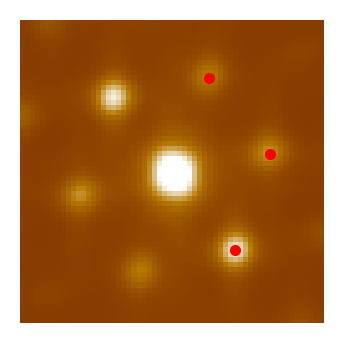

In [297]:
# 원하는 peak 선택
wanted_list = [1,3,4]
lmax_coords_for_affine = lmax_coords[wanted_list]

fig, ax = plt.subplots(1,1)
ax.imshow(topo1fftcrop_gaussian, origin=origin, vmin=vmin, vmax=vmax, cmap=nanox(), aspect=aspect)
ax.plot(lmax_coords_for_affine[:, 1], lmax_coords_for_affine[:, 0], 'r.')
ax.axis('off')

# 좌표 center 맞추기 (center = [0,0])
lmax_coords_center = lmax_coords_for_affine-topo1fftcrop.shape[0]/2
print(lmax_coords_center)

In [332]:
# 원점과 좌표들 사이의 mean distance
mean_r = []
for i in range(0,len(lmax_coords_center)):
    mean_r.append(distance.euclidean(lmax_coords_center[i], [0,0]))

mean_r = np.mean(mean_r, axis=0)
print('mean_r:',mean_r)

mean_r: 19.624772427520913


In [403]:
# peak position assigned
y1, x1 = lmax_coords_center[0]
y2, x2 = lmax_coords_center[1]
y3, x3 = lmax_coords_center[2]

# Slope of each peak positions
a1 = y1/x1

# Angle between positions calculated
theta_12 = math.atan(y1/x1) - math.atan(y2/x2)
theta_13 = math.atan(y1/x1) - math.atan(y3/x3)
print('theta_12:',theta_12*180/math.pi,' theta_13 :',theta_13*180/math.pi)

# The new peak position calculated (distance between [0,0] & [x1_new,y1_new] = mean_r)
x1_new = np.sign(x1) * mean_r / math.sqrt(1 + a1**2)
y1_new = a1 * x1_new
print('x1_new :',x1_new, 'y1_new :', y1_new)

# Angle, the multiple of 60 degree
int_the_12 = round(theta_12*180/math.pi/60) 
int_the_13 = round(theta_13*180/math.pi/60)

# The slopes of a2 and a3 calculated
a2 = math.tan(math.atan(a1) - int_the_12 * math.pi/180 * 60)
a3 = math.tan(math.atan(a1) - int_the_13 * math.pi/180 * 60)

# The new peak positions (2th, 3rd) calculated ( the angle between [x1_new,y1_new] & [x2_new,y2_new] = int_the_12 * pi/3)
x2_new = np.sign(x2) * mean_r / math.sqrt(1 + a2**2)
y2_new = a2 * x2_new
print('x2_new :', x2_new, 'y2_new :', y2_new)

x3_new = np.sign(x3) * mean_r / math.sqrt(1 + a3**2)
y3_new = a3 * x3_new
print('x3_new :', x3_new, 'y3_new :', y3_new)

theta_12: 63.22884978553789  theta_13 : 121.11533231474185
x1_new : 12.25949814485493 y1_new : 15.324372681068663
x2_new : 19.401045111293175 y2_new : -2.9548504905582345
x3_new : 7.141546966438248 y3_new : -18.2792231716269


In [405]:
# affine transformation using the new three peaks
rows, cols = ScanPixels

pt1 = np.float32([[x1, y1] ,[x2, y2] ,[x3, y3]]) + ScanPixels[0]/2
pt2 = np.float32([[x1_new, y1_new], [x2_new, y2_new], [x3_new, y3_new]]) + ScanPixels[0]/2

# Affine transformation
matrix = cv2.getAffineTransform(pt1, pt2)
topo1fft_affine = cv2.warpAffine(topo1fft, matrix, (cols, rows))
# topo1_affine = cv2.warpAffine()

In [430]:
# 역격자 포인트 구하기
# 데이터 픽 좌표
x1_inv = y2-y3
y1_inv = -(x2-x3)
x2_inv = y1-y3
y2_inv = -(x1-x3)
x3_inv = y1-y2
y3_inv = -(x1-x2)

# 대칭성을 가지는 새로운 픽의 좌표
x1_new_inv = y2_new - y3_new
y1_new_inv = -(x2_new - x3_new)
x2_new_inv = y1_new - y3_new
y2_new_inv = -(x1_new - x3_new)
x3_new_inv = y1_new - y2_new
y3_new_inv = -(x1_new - x2_new)

In [432]:
# 기준 포인트 역격자에 해당하는 Affine transformation 구하기
# 전 후 좌표 변수 선언
pt1_inv = np.float32([[x1_inv, y1_inv] ,[x2_inv, y2_inv] ,[x3_inv, y3_inv]]) + ScanPixels[0]/2
pt2_inv = np.float32([[x1_new_inv, y1_new_inv], [x2_new_inv, y2_new_inv], [x3_new_inv, y3_new_inv]]) + ScanPixels[0]/2

# 아핀 매트릭스 구하고 실공간 이미지에 적용하기
matrix_inv = cv2.getAffineTransform(pt1_inv, pt2_inv)
topo1_affine = cv2.warpAffine(topo1, matrix_inv, (cols, rows))
# topo1_affine = cv2.warpAffine(topo1, matrix, (cols, rows))

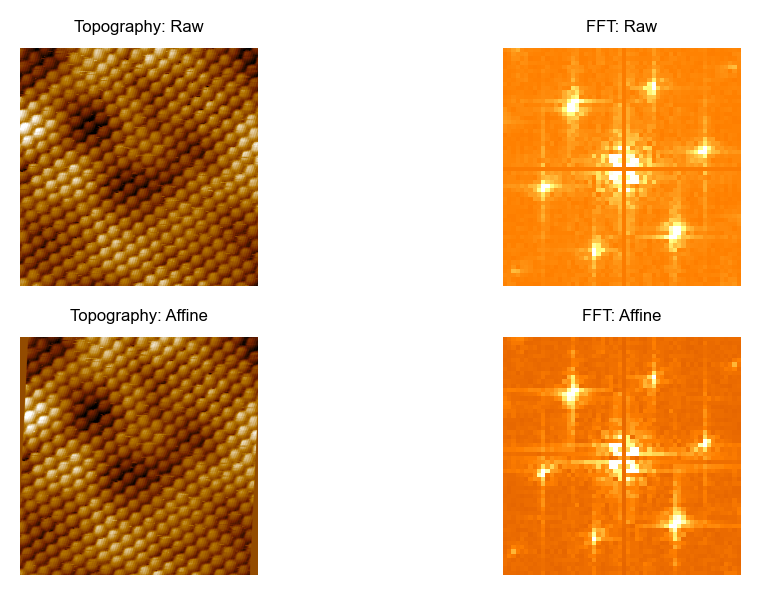

In [451]:
fig, ax = plt.subplots(2,2,figsize = (6,3))

# Topo sigma
# cmap_topo = 'afmhot'
cmap_topo = nanox()
# cmap_topo = 'pink'
# cmap_topo = 'ocean'
sigma = 3
vmin = np.nanmean(topo1) - sigma*np.nanstd(topo1) # 3-sigma
vmax = np.nanmean(topo1) + sigma*np.nanstd(topo1)

center = round(ScanPixels[0]/2)
# croppx = 240
croppx = 256
topo1_crop = topo1[center-croppx:center+croppx, center-croppx:center+croppx] 
topo1_affine_crop = topo1_affine[center-croppx:center+croppx, center-croppx:center+croppx] 
ax[0,0].imshow(topo1_crop, origin=origin, vmin=vmin, vmax=vmax, cmap=cmap_topo, aspect=aspect)
ax[1,0].imshow(topo1_affine_crop, origin=origin, vmin=vmin, vmax=vmax, cmap=cmap_topo, aspect=aspect)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[0,0].set_title('Topography: Raw', fontsize=6)
ax[0,1].set_title('FFT: Raw', fontsize=6)
ax[1,0].set_title('Topography: Affine', fontsize=6)
ax[1,1].set_title('FFT: Affine', fontsize=6)



# FFT sigma
# cmap_fft = 'Purples'
# cmap_fft = 'gist_gray'
cmap_fft = 'afmhot'
sigma = 30
vmin = np.nanmean(topo1fft) - sigma*np.nanstd(topo1fft) 
vmax = np.nanmean(topo1fft) + sigma*np.nanstd(topo1fft)

# FFT image crop 
croppx = 28
# croppx = 256

center = round(ScanPixels[0]/2)
topo1fft_crop = topo1fft[center-croppx:center+croppx, center-croppx:center+croppx]

center = round(topo1_affine_crop.shape[0]/2)
# topo1fft_affine_crop = topo1fft_affine[center-croppx:center+croppx, center-croppx:center+croppx]
topo1fft_affine_crop = fft.two_d_FFT_lin(topo1_affine_crop)[center-croppx:center+croppx, center-croppx:center+croppx]

ax[0,1].imshow(topo1fft_crop, origin=origin, vmin=vmin, vmax=vmax, cmap=cmap_fft, aspect=aspect)

sigma = 4
vmin = np.nanmean(topo1fft_affine_crop) - sigma*np.nanstd(topo1fft_affine_crop) 
vmax = np.nanmean(topo1fft_affine_crop) + sigma*np.nanstd(topo1fft_affine_crop)
ax[1,1].imshow(topo1fft_affine_crop, origin=origin, vmin=vmin, vmax=vmax, cmap=cmap_fft, aspect=aspect)
# ax[1].set_title('linear fit (fast axis only)', fontsize=6)

plt.tight_layout(pad=1)